# Integration

In [1]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

## Simple Integration... Let's start with just 1D integral

### Data Generation

In [2]:
# data = np.load('toy_data_10e4.npz') ## g = y = cos(x1 + 2*x2 + 0.5x3 + alpha0) 3d
data = np.load('cos1d_data_10e4.npz') ## g = y = cos(x1 + alpha0) 1d

In [3]:
Xdata = data['xdata']
print(Xdata)

[[1.70477594 0.        ]
 [3.37372817 0.01002004]
 [0.10208212 0.02004008]
 ...
 [0.1794528  4.97995992]
 [2.07330657 4.98997996]
 [1.39937121 5.        ]]


In [4]:
Ydata = data['ydata']
print(Ydata)

[-0.13357914 -0.97082334  0.99255235 ...  0.43228364  0.71084235
  0.99325801]


### Circuit Model

In [5]:
dev_stochastic = qml.device("lightning.qubit", wires=10)

@qml.qnode(dev_stochastic, interface="autograd", diff_method="parameter-shift")
def single_data_point_ansatz(params, phis, x, num_layers):
    x = np.array(x, ndmin=1)  # `x`를 항상 배열로 처리
    num_qubits = math.ceil(len(x) / 2)
    param_index = 0

    for _ in range(num_layers):
        for i in range(len(x)):
        # for i in range(x.shape[-1]):
            qubit = i // 2
            qml.RY(params[param_index], wires=qubit)
            qml.RZ(params[param_index+1]*x[i], wires = qubit, id = f'x{i}') # Re-uploading data here
            # qml.RZ(x[i], wires=qubit)  # Re-uploading data here
            qml.RZ(params[param_index + 2], wires=qubit)
            qml.RY(params[param_index + 3], wires=qubit)
            qml.RZ(params[param_index + 4], wires=qubit)
            param_index += 5
        
        if num_qubits > 1:
            for q in range(0, num_qubits - 1, 1):
                qml.CZ(wires=[q, q + 1])
            if num_qubits > 2:
                qml.CZ(wires=[num_qubits - 1, 0])
    
    for i in range(num_qubits):
        qml.RY(phis[i], wires=i)

    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)
    
    return qml.expval(obs)

def batch_ansatz(params, phis, xdata, num_layers):
    # Ensure that `params` is a flat list for single_data_point_ansatz
    flat_params = params.flatten()
    
    # Calculate the expectation for each data point and take the mean
    expectations = [single_data_point_ansatz(flat_params, phis, x, num_layers) for x in xdata]
    # return np.mean(expectations)
    return expectations

/home/kban/.local/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


[0.64664235 0.39727659 0.03008858 0.42005655 0.84248538 0.94852055
 0.68273613 0.07571792 0.52649497 0.48852272 0.42942317 0.8717191
 0.11841888 0.87751983 0.33233902 0.48961406 0.79461125 0.23615176
 0.726518   0.29294174]


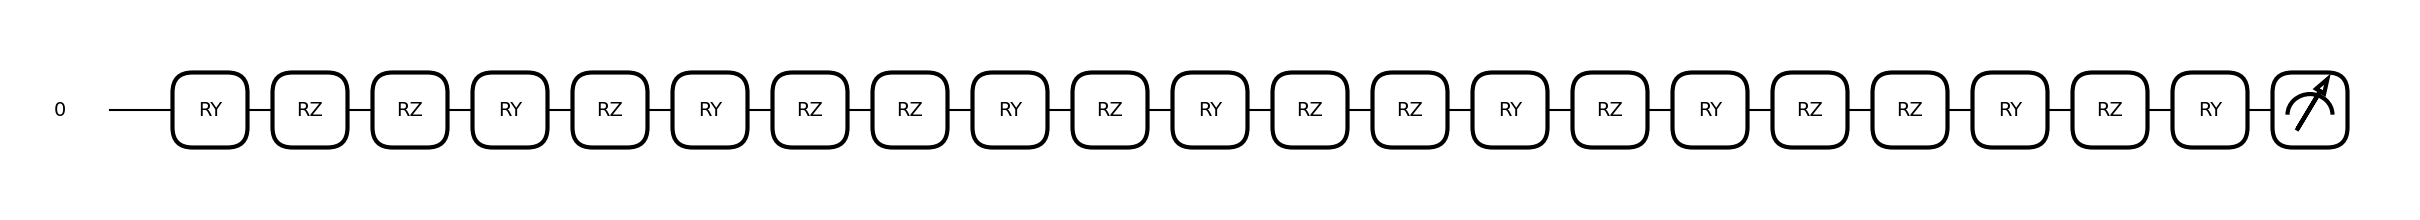

In [6]:
xdim = 2
num_qubits = math.ceil(xdim / 2)
num_layers = 2

N = 300
xdata = Xdata[:N] #np.random.uniform(size = [100,xdim], requires_grad=False)
target = Ydata[:N]

xdata_val = Xdata[N:N+50]
target_val = Ydata[N:N+50]

thetas = np.random.uniform(size = xdim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size=(num_qubits,), requires_grad =True)

print(thetas)

params = 0
params += thetas
param_index = 1
for _ in range(num_layers):
    for j in range(xdim):
        params[param_index] = thetas[param_index] * xdata[0][j]
        param_index += 5

fig, ax = qml.draw_mpl(single_data_point_ansatz)(params, phis, xdata[0], num_layers)
plt.show()

### Loss function

In [7]:
from scipy.optimize import minimize
from copy import deepcopy

In [8]:
def cost_function(params, phis, xdata, target, num_layers, normalize=True):
    # Generate predictions using the provided ansatz
    predictions = batch_ansatz(params, phis, xdata, num_layers)
    
    # Normalize target values if requested
    if normalize:
        norm = np.abs(target) + 1e-7  # Adding a small value to avoid division by zero
    else:
        norm = 1.0
    
    # Calculate normalized MSE loss
    loss = np.mean(((predictions - target) ** 2) / norm)
    return loss

In [9]:
def parameter_shift_term(qnode, params, phis, index, x, num_layers, is_phi=False):
    # 파라미터 시프트의 크기
    shift = np.pi / 2

    if not is_phi:
        # 파라미터 복사 및 시프트
        shifted_params = deepcopy(params)
        # 전진 시프트
        shifted_params[index] += shift
        forward = qnode(shifted_params, phis, x, num_layers)
        # 후진 시프트
        shifted_params[index] -= 2 * shift
        backward = qnode(shifted_params, phis, x, num_layers)
    else:
        # phis에 대한 시프트
        shifted_phis = deepcopy(phis)
        # 전진 시프트
        shifted_phis[index] += shift
        forward = qnode(params, shifted_phis, x, num_layers)
        # 후진 시프트
        shifted_phis[index] -= 2 * shift
        backward = qnode(params, shifted_phis, x, num_layers)

    # 그라디언트 계산
    gradient = (forward - backward) / (2 * np.sin(shift))
    return gradient

def parameter_shift_grad(qnode, params, phis, x, num_layers):
    gradients_params = np.zeros_like(params)
    gradients_phis = np.zeros_like(phis)
    
    # params에 대한 그라디언트 계산
    for i in range(len(params)):
        gradients_params[i] = parameter_shift_term(qnode, params, phis, i, x, num_layers)
    
    # phis에 대한 그라디언트 계산
    for i in range(len(phis)):
        gradients_phis[i] = parameter_shift_term(qnode, params, phis, i, x, num_layers, is_phi=True)
        
    return gradients_params, gradients_phis

In [10]:
def optimize_epoch(params, phis, xdata, target, num_layers, maxiter=100):
    combined_params = np.concatenate([params, phis], requires_grad=True)

    def objective(combined_params):
        # 분리
        num_params = len(params)
        params_ = combined_params[:num_params]
        phis_ = combined_params[num_params:]
        loss = cost_function(params_, phis_, xdata, target, num_layers)
        return loss

    def gradient(combined_params):
        # 결합된 파라미터를 분리합니다.
        num_params = len(params)
        params_ = combined_params[:num_params].reshape(params.shape)
        phis_ = combined_params[num_params:].reshape(phis.shape)

        # xdata의 각 데이터 포인트에 대해 그라디언트를 계산하고, 평균을 구합니다.
        grads_params_total = np.zeros_like(params_)
        grads_phis_total = np.zeros_like(phis_)

        for x in xdata:
            grads_params, grads_phis = parameter_shift_grad(single_data_point_ansatz, params_, phis_, x, num_layers)
            grads_params_total += grads_params
            grads_phis_total += grads_phis

        # 평균 그라디언트를 계산합니다.
        grads_params_mean = grads_params_total / len(xdata)
        grads_phis_mean = grads_phis_total / len(xdata)

        # 결합된 평균 그라디언트를 반환합니다.
        combined_grads = np.concatenate([grads_params_mean, grads_phis_mean])
        return combined_grads



    # 최적화 실행
    result = minimize(objective, combined_params, method='L-BFGS-B', # jac=gradient, #(auto-grad)
                      options={'maxiter': maxiter, 'gtol': 1e-12, 'ftol': 1e-18})

    # 분리 및 재구성
    optimized_params = result.x[:len(params)]
    optimized_phis = result.x[len(params):]
    
    return optimized_params, optimized_phis, result.fun

# 검증 손실을 계산하기 위한 함수
def validate(params, phis, xdata_val, target_val, num_layers):
    loss = cost_function(params, phis, xdata_val, target_val, num_layers)
    return loss

In [11]:
# 전체 최적화 과정을 여러 epoch에 걸쳐 실행
epochs = 300
for epoch in range(epochs):
    optimized_params, optimized_phis, loss = optimize_epoch(params, phis, xdata, target, num_layers, maxiter=1)
    params, phis = optimized_params, optimized_phis  # 최적화된 파라미터 업데이트
    
    # 검증 손실 계산 (xdata_val, target_val을 적절히 정의해야 함)
    val_loss = validate(params, phis, xdata_val, target_val, num_layers)
    
    print(f"Epoch {epoch+1}: Training Loss = {loss}, Validation Loss = {val_loss}")

# 최종 최적화된 파라미터와 손실 출력
print(f"Final Loss: {loss}")
print("Optimized Parameters for params:", params)
print("Optimized Parameters for phis:", phis)


Epoch 1: Training Loss = 0.8667141524755891, Validation Loss = 1.1669755821873127
Epoch 2: Training Loss = 0.5125960732605146, Validation Loss = 0.6441610503952984
Epoch 3: Training Loss = 0.468660996168306, Validation Loss = 0.4532058283851091
Epoch 4: Training Loss = 0.463291384695907, Validation Loss = 0.7077449350149371
Epoch 5: Training Loss = 0.3943900403018132, Validation Loss = 0.4398358089953343
Epoch 6: Training Loss = 0.28973995567649, Validation Loss = 0.5203279757364035
Epoch 7: Training Loss = 0.248741215413332, Validation Loss = 0.32324863282686833
Epoch 8: Training Loss = 0.2084602437842798, Validation Loss = 0.32801453438619516
Epoch 9: Training Loss = 0.18843440185921212, Validation Loss = 0.2206351253451016
Epoch 10: Training Loss = 0.172721057403515, Validation Loss = 0.24650497757920004
Epoch 11: Training Loss = 0.16268322297878227, Validation Loss = 0.18060982548236026
Epoch 12: Training Loss = 0.154345967099969, Validation Loss = 0.21450856124040446
Epoch 13: Tra

In [12]:
print(f"Epoch {epoch+1}: Training Loss = {loss}, Validation Loss = {val_loss}")

Epoch 300: Training Loss = 0.002575694787122822, Validation Loss = 0.02296519811467896


### Check the results

In [13]:
predictions = batch_ansatz(params, phis, Xdata[400:420], num_layers)

In [14]:
Ydata[400:420], np.array(predictions)

(array([ 0.68859976,  0.97227901,  0.63050092,  0.78966693,  0.51416276,
         0.95545231,  0.9470455 ,  0.72431934,  0.96773803, -0.55161517,
         0.20404097,  0.95696629,  0.97480826,  0.72071072,  0.39053937,
        -0.41654036,  0.99991996,  0.54218907,  0.8926306 ,  0.87943899]),
 tensor([ 0.73084305,  0.8598283 ,  0.68484606,  0.79884485,  0.60152874,
          0.88546467,  0.88108679,  0.72288382,  0.88665892, -0.11929453,
          0.43644583,  0.85443259,  0.88540796,  0.7414296 ,  0.56095549,
          0.0112602 ,  0.88777094,  0.6528895 ,  0.84120446,  0.83284605], requires_grad=True))

In [15]:
predictions = batch_ansatz(params, phis, Xdata[0:20], num_layers)

In [16]:
Ydata[0:20], np.array(predictions)

(array([-0.13357914, -0.97082334,  0.99255235, -0.98046538, -0.96324292,
        -0.817155  ,  0.45767458,  0.95902655,  0.99646787,  0.36033158,
         0.4533931 ,  0.6208793 , -0.95646062,  0.61212022, -0.13304606,
         0.83947275, -0.61675439, -0.99953003, -0.0376312 , -0.96854291]),
 tensor([-0.18107638, -0.97150306,  0.97570891, -0.98186463, -0.96443364,
         -0.81312678,  0.46166784,  0.98033122,  0.95654709,  0.35576511,
          0.46286922,  0.65578388, -0.94233941,  0.64816873, -0.16453943,
          0.8925385 , -0.62293529, -0.99200888, -0.06279926, -0.96906553], requires_grad=True))

### Plot $g(x)$

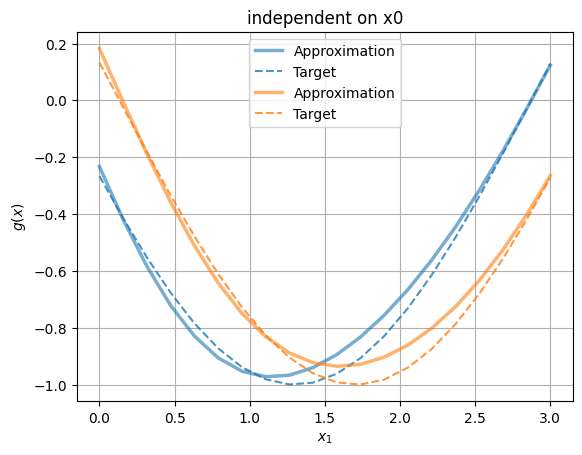

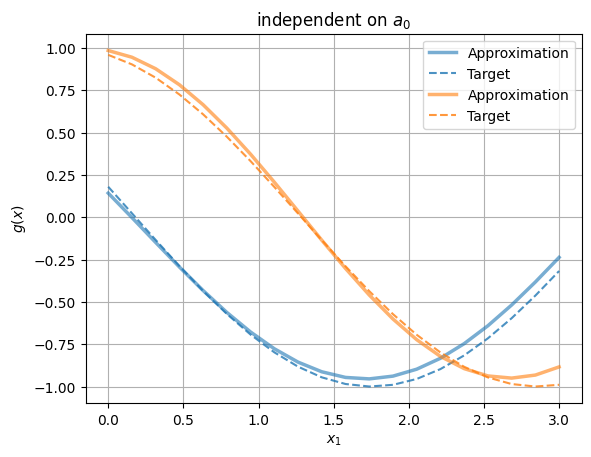

In [17]:
import copy

xmin = [0.0]
xmax = [3.0]
npoints = 20

xmin = np.array(xmin*xdim)
xmax = np.array(xmax*xdim)

def target(x):
    return np.cos(x[0]+x[1])
    # return np.cos(x[0]+2*x[1]+0.5*x[2]+x[3])

for d in range(xdim):
    # Create a linear space in the dimension we are plotting
    xlin = np.linspace(xmin[d], xmax[d], npoints)

    for i in range(xdim):
        # For every extra dimension do an extra plot so that we have more random points
        # in the other dimensions

        # Select a random point in the other dimensions
        xran_origin = np.random.rand(xdim) * (xmax - xmin) + xmin

        ytrue = []
        all_xs = []

        for xx in xlin:
            xran = copy.deepcopy(xran_origin)
            xran[d] = xx
            ytrue.append(target(xran))
            all_xs.append(xran)

        ypred = batch_ansatz(params, phis, all_xs, num_layers)

        if xdim == 2:
            # when there is only 2 dimensions only one variable is fixed
            # and so we can actually write the numerical value
            other_d = (d + 1) % 2
        else:
            tag = f"n={i}"

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(
            xlin,
            ypred,
            label=f"Approximation",
            linewidth=2.5,
            alpha=0.6,
            ls="-",
            color=color,
        )
        plt.plot(
            xlin,
            np.stack(ytrue),
            label=f"Target",
            linewidth=1.5,
            alpha=0.8,
            ls="--",
            color=color,
        )

    plt.grid(True)
    if d == xdim-1:
        plt.title(f"independent on $a_0$")
    else:
        plt.title(f"independent on x"+str(d))

    plt.xlabel(r"$x_1$")

    plt.ylabel(r"$g(x)$")
    plt.legend()
    plt.show()


### How to get the integration values?